<a href="https://colab.research.google.com/github/DarkFlink/aysat_spcn_hackathon_2020/blob/master/Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gen video

from urllib.request import urlopen
from os.path import isfile, join
from urllib import request
import albumentations as A
import PIL.Image
from os import listdir
import numpy as np
import requests
import json
import cv2
import os



def download(url, name): # doesn't work for gdocs
    if os.path.isfile('./' + name):
        return

    # download file
    dir = './'
    filename = os.path.join(dir, name)
    if not os.path.isfile(filename):
        response = urlopen(url)
        CHUNK = 16 * 1024
        with open(filename, 'wb') as f:
            while True:
                chunk = response.read(CHUNK)
                if not chunk:
                    break
                f.write(chunk)


def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)


def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


def download_from_gdocs(url, filename):
    id = url[(url.find('id=') + len('id=')):]
    download_file_from_google_drive(id, filename)


def augmentation(img_mas):
    res = img_mas.copy()
    rotate = A.augmentations.transforms.Rotate(limit=30, p=1)
    el_t = A.augmentations.transforms.ElasticTransform(alpha=10, sigma=20, alpha_affine=50,p=1)
    for img in img_mas:
        res.append(rotate(image=img)['image'])
        res.append(el_t(image=img)['image'])
    return res


def jpeg_from_mp4(path, destination, frame_ind = 1):
    cam = cv2.VideoCapture(path)
    try:
        # creating a folder named data
        if not os.path.exists(destination):
            os.makedirs(destination)
        # if not created then raise error
    except OSError:
        print('Error: Creating directory of data')
    # frame
    currentframe = 0
    frame_id = 0
    while (True):
        # reading from frame
        ret, frame = cam.read()

        if ret:
            if currentframe % frame_ind == 0:
                name = f'./{destination}/frame_' + str(frame_id) + '_.jpg'
                print('Creating...' + name)
                new_frame = preproc(frame)
                cv2.imwrite(name, new_frame)
                frame_id += 1
            currentframe += 1
        else:
            break

    # Release all space and windows once done
    cam.release()


def preproc(src_img):
    img = src_img.copy()
    img = cv2.medianBlur(img, 5)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    canny = cv2.Canny(img,100,200)
    return canny


def load_images(path = './data'):
    images_paths = []
    dir_tree = os.walk(path)
    folder = []
    valid_images = [".jpg", ".png", ".jpeg"]
    for el in dir_tree:
        if el[0] is path:
            continue
        folder.append(el)
    for address, dirs, files in folder:
        for file in files:
            for form in valid_images:
                if form in file:
                    images_paths.append(address + '/' + file)
    return load_images_from_path(images_paths)


def load_images_from_path(imgs_with_paths):
    images = []
    print(imgs_with_paths)
    for img in imgs_with_paths:
        img = cv2.imread(img)
        images.append(cv2.resize(img, (224, 224)))
    return images


def process_video(url, path, skip_rate=9, filename='data.mp4'):
    download(url, filename)
    jpeg_from_mp4(filename, path, skip_rate)



def get_train_x_y(_dir_path='./data'):
    x_data, y_data = [], []
    for dir_name in listdir(_dir_path):
        dir_path = f'{_dir_path}/{dir_name}'
        onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) and '.json' in f]
        for filename in onlyfiles:
            print(f'{_dir_path}/{dir_name}/{filename}')
            with open(f'{_dir_path}/{dir_name}/{filename}') as file:
                data_json = json.load(file)
            for element in data_json:
                key = list(element.keys())[0]
                label = element[key]
                y_data.append(label)
             #   img = PIL.Image.open(key)
             #   x_data.append(np.asarray(img))
                x_data.append(np.asarray(load_images_from_path([key])[0]))
    return np.asarray(x_data), np.asarray(y_data)


process_video(url='http://ipfs.duckietown.org:8080/ipfs/QmUbtwQ3QZKmmz5qTjKM3z8LJjsrKBWLUnnzoE5L4M7y7J/logs/20160430182226_quackmob.video.mp4', path=f'data/video1', filename='data1.mp4')
process_video(url='http://ipfs.duckietown.org:8080/ipfs/QmUbtwQ3QZKmmz5qTjKM3z8LJjsrKBWLUnnzoE5L4M7y7J/logs/20160512194050_morty.video.mp4', path=f'data/video2', skip_rate=18, filename='data2.mp4')
process_video(url='http://ipfs.duckietown.org:8080/ipfs/QmUbtwQ3QZKmmz5qTjKM3z8LJjsrKBWLUnnzoE5L4M7y7J/logs/20160429225147_neptunus.video.mp4', path=f'data/video3', skip_rate=5, filename='data3.mp4')

!wget https://raw.githubusercontent.com/DarkFlink/aysat_spcn_hackathon_2020/master/data/video1/dataset_part1.json -O /content/data/video1/markup.json
!wget https://raw.githubusercontent.com/DarkFlink/aysat_spcn_hackathon_2020/master/data/video2/markup.json -O /content/data/video2/markup.json
!wget https://raw.githubusercontent.com/DarkFlink/aysat_spcn_hackathon_2020/master/data/video3/markup.json?token=AHQWAQ3DK2EZAFYNPPS3ET27VLUAI -O /content/data/video3/markup.json


Creating..../data/video1/frame_0_.jpg
Creating..../data/video1/frame_1_.jpg
Creating..../data/video1/frame_2_.jpg
Creating..../data/video1/frame_3_.jpg
Creating..../data/video1/frame_4_.jpg
Creating..../data/video1/frame_5_.jpg
Creating..../data/video1/frame_6_.jpg
Creating..../data/video1/frame_7_.jpg
Creating..../data/video1/frame_8_.jpg
Creating..../data/video1/frame_9_.jpg
Creating..../data/video1/frame_10_.jpg
Creating..../data/video1/frame_11_.jpg
Creating..../data/video1/frame_12_.jpg
Creating..../data/video1/frame_13_.jpg
Creating..../data/video1/frame_14_.jpg
Creating..../data/video1/frame_15_.jpg
Creating..../data/video1/frame_16_.jpg
Creating..../data/video1/frame_17_.jpg
Creating..../data/video1/frame_18_.jpg
Creating..../data/video1/frame_19_.jpg
Creating..../data/video1/frame_20_.jpg
Creating..../data/video1/frame_21_.jpg
Creating..../data/video1/frame_22_.jpg
Creating..../data/video1/frame_23_.jpg
Creating..../data/video1/frame_24_.jpg
Creating..../data/video1/frame_25_.

data  data1.mp4  data2.mp4  data3.mp4  sample_data
/content
['left' 'left' 'left' ... 'left' 'left' 'left']
Epoch: 0, loss: 1.31157, val_loss: 0.98135
                val_acc: 0.60678
Epoch: 1, loss: 0.88737, val_loss: 0.84471
                val_acc: 0.69153
Epoch: 2, loss: 0.61368, val_loss: 0.77406
                val_acc: 0.67458
Epoch: 3, loss: 0.45110, val_loss: 0.67024
                val_acc: 0.74237
Epoch: 4, loss: 0.35610, val_loss: 0.61220
                val_acc: 0.78305
Epoch: 5, loss: 0.25926, val_loss: 0.62416
                val_acc: 0.76949
Epoch: 6, loss: 0.21822, val_loss: 0.57777
                val_acc: 0.77966
Epoch: 7, loss: 0.16446, val_loss: 0.58479
                val_acc: 0.76949
Epoch: 8, loss: 0.13724, val_loss: 0.57070
                val_acc: 0.79322
Epoch: 9, loss: 0.11275, val_loss: 0.58845
                val_acc: 0.77627
Epoch: 10, loss: 0.10064, val_loss: 0.58197
                val_acc: 0.81356
Epoch: 11, loss: 0.07437, val_loss: 0.53486
           

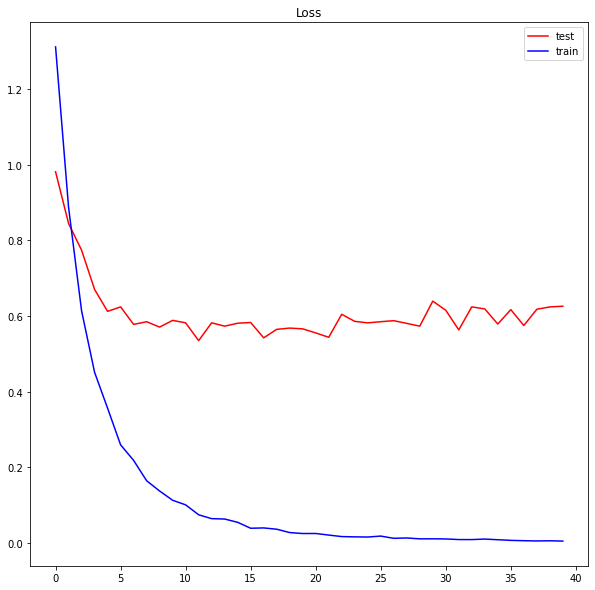

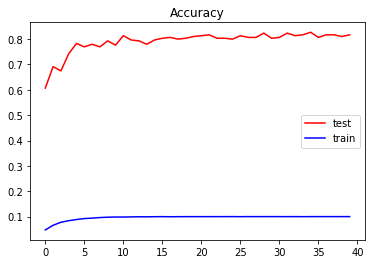

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [26]:
!ls && pwd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split

epochs = 40
batch_size = 10
learn_rate = 0.0001
num_classes = 6
tiles = {"right":0, "left":1, "straight":2, "three_cross":3, "four_cross":4, "empty":5}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class DuckieRoadDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, Y):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.Y = Y
        self.X = X

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = [self.X[idx].reshape((3,224,224)), self.Y[idx]]

        return sample


class RoadNet(nn.Module):
    def __init__(self):
        super(RoadNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.batn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.1)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.batn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.1)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.batn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.drop3 = nn.Dropout(p=0.1)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.batn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.drop4 = nn.Dropout(p=0.1)

        self.fc = nn.Linear(in_features=14 * 14 * 64, out_features=6)

    def forward(self, input):
      #  print(input.shape)
        output = self.conv1(input.float())
        output = self.relu1(output)
        output = self.batn1(output)
        output = self.pool1(output)
        output = self.drop1(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.batn2(output)
        output = self.pool2(output)
        output = self.drop2(output)

        output = self.conv3(output)
        output = self.relu3(output)
        output = self.batn3(output)
        output = self.pool3(output)
        output = self.drop3(output)

        output = self.conv4(output)
        output = self.relu4(output)
        output = self.batn4(output)
        output = self.pool4(output)
        output = self.drop4(output)

        output = output.view(-1, 14 * 14 * 64)
        output = self.fc(output)

        return output

classifier = RoadNet()
classifier.to(device)
crossentropy_loss = nn.CrossEntropyLoss()
opt = Adam(classifier.parameters(), lr=learn_rate)

x_data, y_data = get_train_x_y('/content/data/')
print(y_data)
x_data = x_data / 255.0
#x_data = x_data[:250]
#y_data = y_data[:250]
y_data = [tiles[i] for i in y_data]

train_X, test_X, train_Y, test_Y = train_test_split(x_data, y_data, test_size=0.2)

train_data = DuckieRoadDataset(
    X = train_X,
    Y = train_Y
)
test_data = DuckieRoadDataset(
    X = test_X,
    Y = test_Y
)

#train_data = CIFAR10(root='./datasets/', train=True, download=True, transform=transform)
#test_data = CIFAR10(root='./datasets/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

history_test_loss = []
history_train_loss = []
history_test_acc = []
history_train_acc = []

# fit model
# main epochs for
for epoch in range(epochs):
    classifier.train()
    # fitting procedure
    train_loss = 0.0
    train_acc = 0.0
    train_total = 0.0
    for idx, (X, Y) in enumerate(train_loader):
        opt.zero_grad()
        X, Y = X.to(device), Y.to(device)
        # forward -->
        model_output = classifier.forward(X)

        # classify model output
        loss_output = crossentropy_loss(model_output, Y)

        # backward <--
        loss_output.backward()

        train_acc += (model_output.argmax(dim=1) == Y).float().mean()
        train_total += Y.size(0)
    #    print("TRAINACC:", train_acc)

        # optimizer need to update weights
        opt.step()

        train_loss += loss_output.cpu().item() * X.size(0)

    # testing
    classifier.eval()
    test_loss = 0.0
    test_acc = 0.0
    correct = 0.0
    total = 0.0
    for idx, (X,Y) in enumerate(test_loader):
        X, Y = X.to(device), Y.to(device)
        model_output = classifier.forward(X)

        loss_output = crossentropy_loss(model_output, Y)

        test_loss += loss_output.cpu().item() * X.size(0)

        correct += (model_output.argmax(dim=1) == Y).sum().item()
        total += Y.size(0)
       # test_acc += (model_output.argmax(dim=1) == Y).float().mean()

    # for tracking history
    test_loss = test_loss / test_X.__len__()
    train_loss = train_loss / train_X.__len__()
 #   test_acc = test_acc * batch_size / test_X.__len__()
    train_acc = train_acc / train_total
    history_train_loss.append(train_loss)
    history_test_loss.append(test_loss)
    history_train_acc.append(train_acc)
    history_test_acc.append(correct/total)

    print(f'Epoch: {epoch}, loss: {train_loss:.5f}, val_loss: {test_loss:.5f}')
    print(f'                val_acc: {correct/total:.5f}')

plt.figure(1, figsize=(10, 10))
plt.title("Loss")
plt.plot(history_test_loss, 'r', label='test')
plt.plot(history_train_loss, 'b', label='train')
plt.legend()
plt.show()
plt.clf()

plt.figure(1, figsize=(10, 10))
plt.title("Accuracy")
plt.plot(history_test_acc, 'r', label='test')
plt.plot(history_train_acc, 'b', label='train')
plt.legend()
plt.show()
plt.clf()

torch.save()